# Сверточные сети на Pytorch


1. Реализовать сверточную сеть на mnist (например, нейронная сеть из второго занятия по сверточным сетям) на Pytorch, поэкспериментировать с ее гиперпараметрами, сравнить результаты.
2. Написать слой BatchNorm(кастомный) и добавить его в НС.
3. Написать оптимизатор RMSProp(кастомный) и сравнить с обычным SGD.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torchvision.transforms as transforms
import torchvision.datasets
import tqdm

from bokeh.plotting import figure
from bokeh.io import show
from bokeh.models import LinearAxis, Range1d
import numpy as np
import time
import matplotlib.pyplot as plt

%matplotlib inline

### Подготовка данных

In [2]:
# Initialize parameters
num_epochs = 5
num_classes = 10 
batch_size = 100 
learning_rate = 0.001
# mu = 0.1307
# sigma = 0.3081
n1=100
n2=10

data_path = 'C:\\Users\mary\PycharmProjects\MNISTData'
store_path = 'C:\\Users\mary\PycharmProjects\pytorch_models\\'

In [3]:
trans = transforms.Compose([transforms.ToTensor()]) # , transforms.Normalize((mu,), (sigma,))

train_dataset = torchvision.datasets.MNIST(root=data_path, train=True, transform=trans, download=True) 
test_dataset = torchvision.datasets.MNIST(root=data_path, train=False, transform=trans)

In [4]:
# Load prepared datasets
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True) 
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

### Создание модели

In [5]:
# Take window size 5*5
# padding = ((size_out-1)*step - size_in + window_size)/2
class CNN(nn.Module):
    
    def __init__(self, n1=n1, n2=n2): 
        super(CNN, self).__init__() # get parent class methods
        self.layer1 = nn.Sequential(nn.Conv2d(1, n1, kernel_size=(5,5), stride=1, padding=2), 
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(nn.Conv2d(n1, n2, kernel_size=(5,5), stride=1, padding=2), 
                                    nn.ReLU(), 
                                    nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc1 = nn.Linear(7 * 7 * n2, 10)
        
    def forward(self, x): # is started with model(x), where model=ConvNet()
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1) 
        out = self.fc1(out) 
        return out

### Применние модели на тренировочных данных

In [6]:
model = CNN()
criterion = nn.CrossEntropyLoss() # softmax + cross entropy
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [13]:
def model_train(model, num_epochs=num_epochs, print_steps=True):
    
    t=time.time()

    # Train the model
    total_step = len(train_loader)
    loss_list = []
    acc_list = []
    
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader): # for x, y in tqdm.tqdm(train_loader)
            # Run the forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss_list.append(loss.item())

            # Backprop and perform optimisation
            optimizer.zero_grad() # make gradients = zero          
            loss.backward() # compute gradients
            optimizer.step() # recalculate weights

            # Track the accuracy
            total = labels.size(0) # batch_size 
            _, predicted = torch.max(outputs.data, dim=1) # dim=1
            correct = (predicted == labels).sum().item() # after .sum() we still have tensor, so use .item() then
            acc_list.append(correct / total)
            
            if print_steps==True:
                if (i + 1) % 100 == 0:
                    print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                          .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                                  (correct / total) * 100))
    print('Time to train: {} minutes'.format(np.round((time.time()-t)/60, 2)))
    plt.figure(figsize=(12,5))
    plt.title('Loss')
    plt.plot(loss_list);
    plt.show()

Epoch [1/3], Step [100/600], Loss: 2.2749, Accuracy: 18.00%
Epoch [1/3], Step [200/600], Loss: 2.2480, Accuracy: 28.00%
Epoch [1/3], Step [300/600], Loss: 2.2193, Accuracy: 37.00%
Epoch [1/3], Step [400/600], Loss: 2.1409, Accuracy: 54.00%
Epoch [1/3], Step [500/600], Loss: 2.1106, Accuracy: 51.00%
Epoch [1/3], Step [600/600], Loss: 2.0183, Accuracy: 62.00%
Epoch [2/3], Step [100/600], Loss: 1.8834, Accuracy: 68.00%
Epoch [2/3], Step [200/600], Loss: 1.6774, Accuracy: 74.00%
Epoch [2/3], Step [300/600], Loss: 1.5610, Accuracy: 72.00%
Epoch [2/3], Step [400/600], Loss: 1.2995, Accuracy: 77.00%
Epoch [2/3], Step [500/600], Loss: 1.1071, Accuracy: 79.00%
Epoch [2/3], Step [600/600], Loss: 0.9345, Accuracy: 84.00%
Epoch [3/3], Step [100/600], Loss: 0.8143, Accuracy: 86.00%
Epoch [3/3], Step [200/600], Loss: 0.8461, Accuracy: 78.00%
Epoch [3/3], Step [300/600], Loss: 0.7170, Accuracy: 81.00%
Epoch [3/3], Step [400/600], Loss: 0.6675, Accuracy: 85.00%
Epoch [3/3], Step [500/600], Loss: 0.637

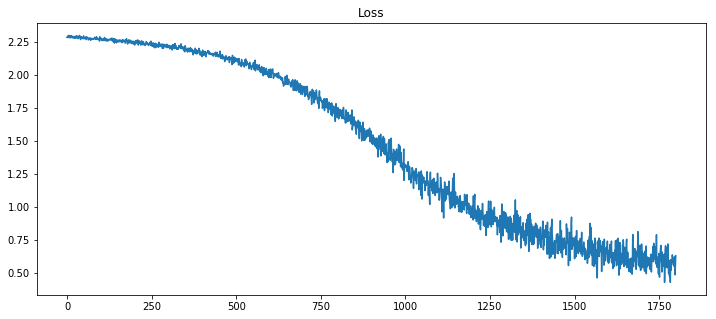

In [8]:
model_train(model, 3)

### Использование на тестовых данных

In [9]:
# Test the model
def model_test(model):
    
    t=time.time()

    model.eval()
    with torch.no_grad(): # turn off autogradient
        correct = 0
        total = 0
        for images, labels in test_loader:
            # Predict
            outputs = model(images)

            # Track the accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Test Accuracy on 10 000 test images: {} %'.format((correct / total) * 100))
    print('Time to test: {} minutes'.format(np.round((time.time()-t)/60, 2)))

In [10]:
model_test(model)

Test Accuracy on 10 000 test images: 86.72 %
Time to test: 0.24 minutes


### Эксперименты с гиперпараметрами

Попробуем теперь следующие вариации модели (без слоя дропаут, батч норма, оптимизатор - SGD) и параметров:
* будем менять: 
    * количество эпох [3, 5, 7]
    * скорость обучения [0.001, 0.01, 0.1]
    * количество нейронов в слое 1 [1, 10, 100, 500]
    * количество нейронов в слое 2 [1, 10, 100]

Parameter = 3
Time to train: 6.15 minutes


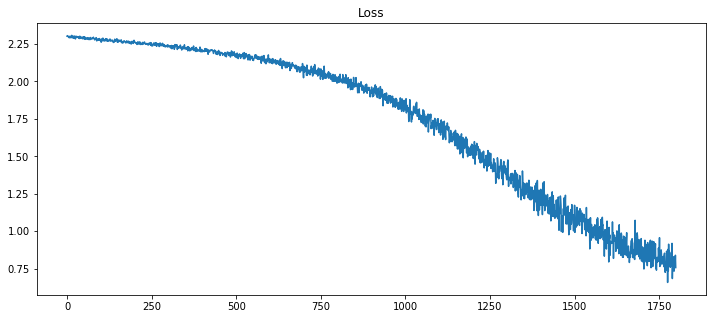

Test Accuracy on 10 000 test images: 82.95 %
Time to test: 0.14 minutes
Parameter = 5
Time to train: 10.21 minutes


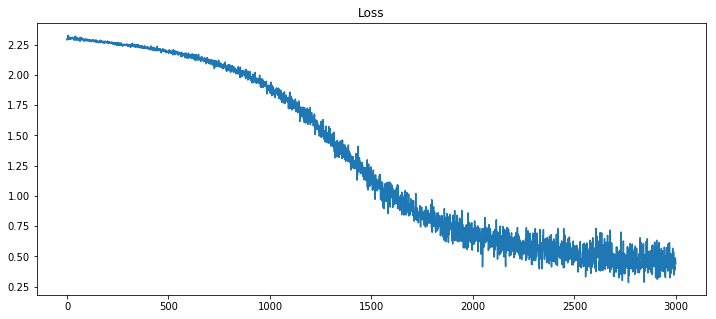

Test Accuracy on 10 000 test images: 88.36 %
Time to test: 0.15 minutes
Parameter = 7
Time to train: 14.34 minutes


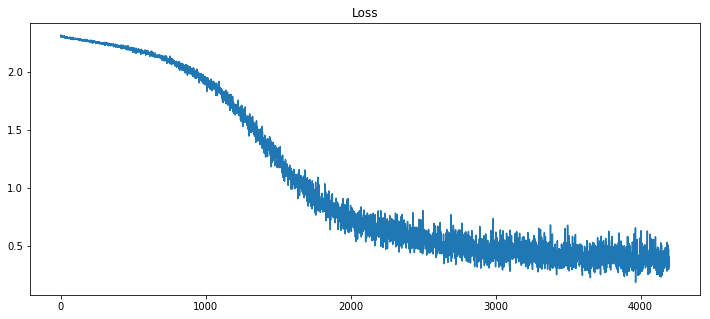

Test Accuracy on 10 000 test images: 89.99000000000001 %
Time to test: 0.14 minutes
Parameter = 9
Time to train: 18.96 minutes


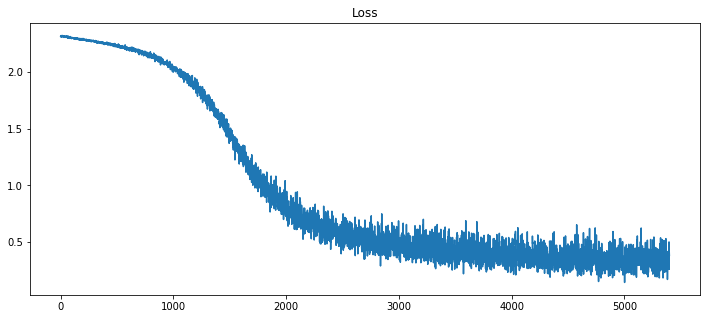

Test Accuracy on 10 000 test images: 91.43 %
Time to test: 0.14 minutes


In [15]:
n1=30
n2=60
for epochs in [3,5,7,9]:
    
    model = CNN(n1=n1, n2=n2)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    print('Parameter = ' + str(epochs))
    model_train(model, num_epochs=epochs, print_steps=False)
    model_test(model)
    print('------------------')

Parameter = 0.001
Time to train: 10.49 minutes


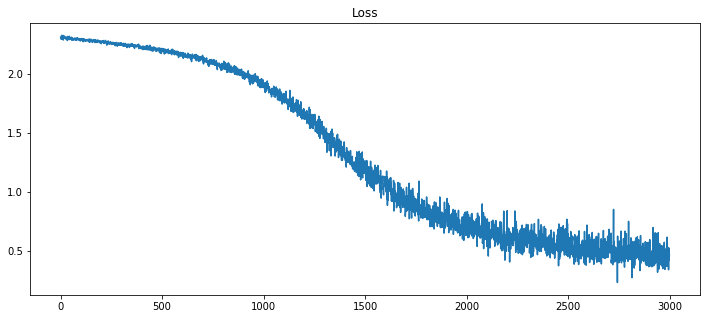

Test Accuracy on 10 000 test images: 88.06 %
Time to test: 0.14 minutes
Parameter = 0.01
Time to train: 10.18 minutes


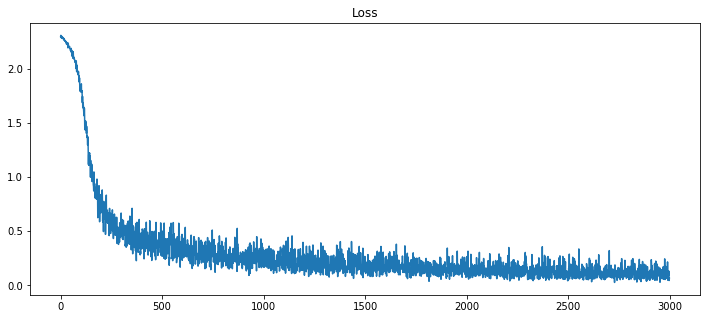

Test Accuracy on 10 000 test images: 97.15 %
Time to test: 0.15 minutes
Parameter = 0.1
Time to train: 10.35 minutes


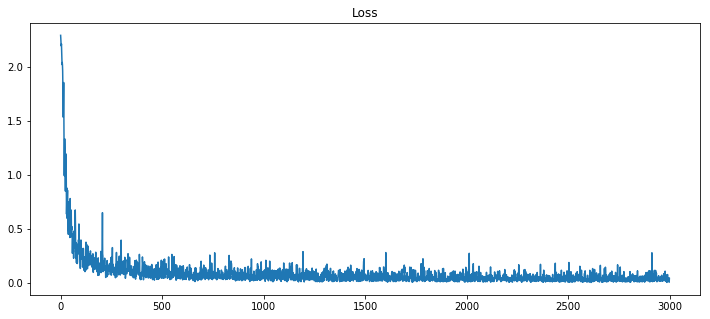

Test Accuracy on 10 000 test images: 98.5 %
Time to test: 0.14 minutes


In [17]:
for lr in [0.001, 0.01, 0.1]:
    
    model = CNN(n1=n1, n2=n2)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    print('Parameter = ' + str(lr))
    model_train(model, num_epochs=5, print_steps=False)
    model_test(model)
    print('------------------')

Parameter = 10
Time to train: 3.28 minutes


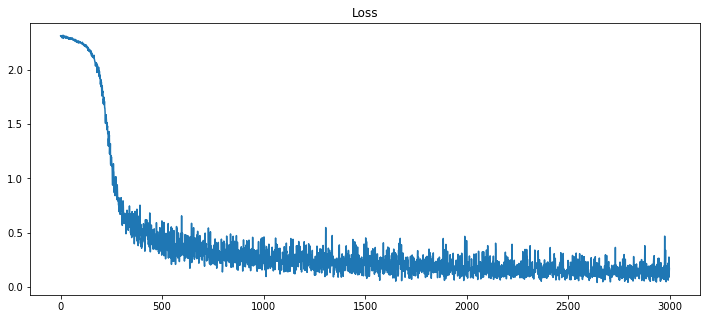

Test Accuracy on 10 000 test images: 96.3 %
Time to test: 0.06 minutes
------------------
Parameter = 50
Time to train: 9.34 minutes


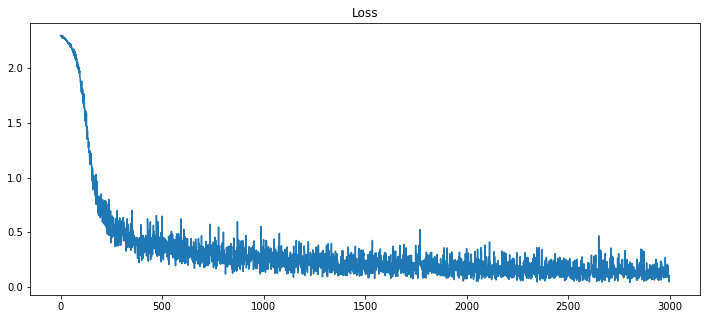

Test Accuracy on 10 000 test images: 96.64 %
Time to test: 0.14 minutes
------------------
Parameter = 100
Time to train: 16.88 minutes


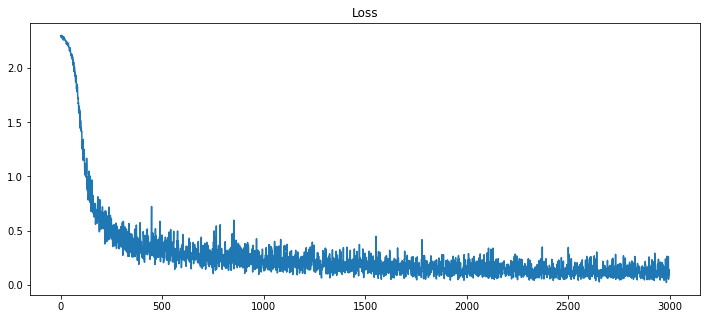

Test Accuracy on 10 000 test images: 97.11 %
Time to test: 0.24 minutes
------------------
Parameter = 300
Time to train: 44.98 minutes


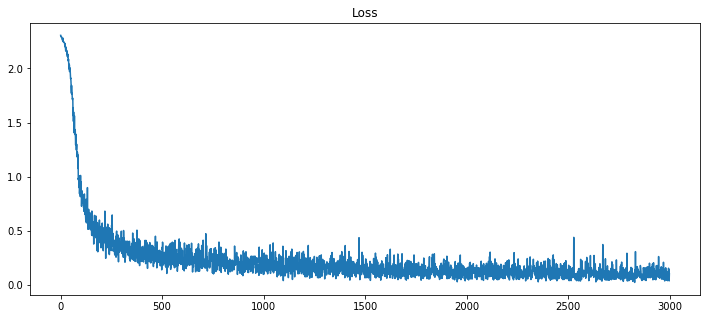

Test Accuracy on 10 000 test images: 97.57000000000001 %
Time to test: 0.64 minutes
------------------


In [20]:
# n1
for n in [10, 50, 100, 300]:
    
    model = CNN(n1=n, n2=10)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    
    print('Parameter = ' + str(n))
    model_train(model, num_epochs=5, print_steps=False)
    model_test(model)
    print('------------------')

Parameter = 10
Time to train: 16.74 minutes


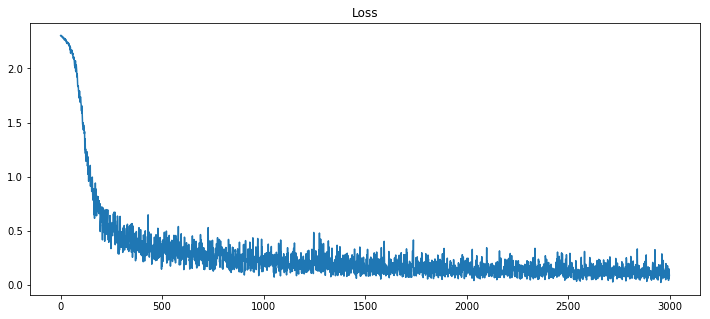

Test Accuracy on 10 000 test images: 96.87 %
Time to test: 0.24 minutes
------------------
Parameter = 50
Time to train: 26.86 minutes


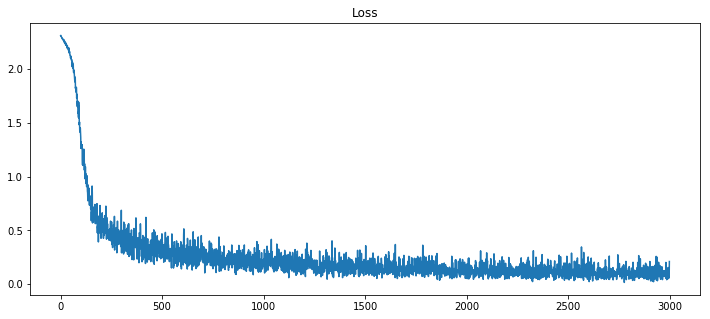

Test Accuracy on 10 000 test images: 97.3 %
Time to test: 0.34 minutes
------------------
Parameter = 100
Time to train: 40.73 minutes


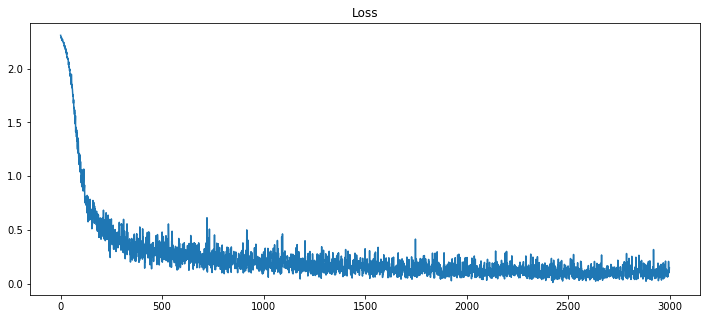

Test Accuracy on 10 000 test images: 97.63 %
Time to test: 0.51 minutes
------------------


In [24]:
# n2
for n in [10, 50, 100]:
    
    model = CNN(n1=100, n2=n)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    
    print('Parameter = ' + str(n))
    model_train(model, num_epochs=5, print_steps=False)
    model_test(model)
    print('------------------')

Нейросеть показывает хороший результат при следующих значениях параметров:
* нейронов в 1 слое 100
* нейронов во 2 слое 50
* скорость обучения 0.01
* эпохи 5

### Добавление BatchNorm к нейросети

In [25]:
class CNN_BN(nn.Module):
    
    def __init__(self, n1=n1, n2=n2): 
        super(CNN_BN, self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(1, n1, kernel_size=(5,5), stride=1, padding=2), 
                                    nn.ReLU(),
                                    # nn.BatchNorm2d(n2),
                                    nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(nn.Conv2d(n1, n2, kernel_size=(5,5), stride=1, padding=2), 
                                    nn.ReLU(), 
                                    # nn.BatchNorm2d(n2), 
                                    nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc1 = nn.Linear(7 * 7 * n2, 10)
        self.bathes_cum = []
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.CustomBatchNorm(out, 1)
        out = self.layer2(out)
        out = self.CustomBatchNorm(out, 2)
        out = out.reshape(out.size(0), -1) 
        out = self.fc1(out) 
        return out
    
    def CustomBatchNorm(self, in_x, gamma=1, beta=1):

        batch_size, channels, height, width = in_x.size(0), in_x.size(1), in_x.size(2), in_x.size(3)
        
        # we should compute statistics for each channel(dimension 1) separately
        mu = torch.mean(in_x, dim=[0,2,3]).reshape(1, channels, 1, 1)
        var =  torch.mean((in_x - mu)**2, dim=[0,2,3]).reshape(1, channels, 1, 1)
        out_x = (in_x - mu)*1. / torch.sqrt((var  + 1e-8))
        # out_x = gamma*out_x + beta?
        return out_x

Epoch [1/5], Step [100/600], Loss: 0.1244, Accuracy: 97.00%
Epoch [1/5], Step [200/600], Loss: 0.1341, Accuracy: 96.00%
Epoch [1/5], Step [300/600], Loss: 0.0554, Accuracy: 100.00%
Epoch [1/5], Step [400/600], Loss: 0.1087, Accuracy: 97.00%
Epoch [1/5], Step [500/600], Loss: 0.0535, Accuracy: 99.00%
Epoch [1/5], Step [600/600], Loss: 0.0816, Accuracy: 99.00%
Epoch [2/5], Step [100/600], Loss: 0.0617, Accuracy: 99.00%
Epoch [2/5], Step [200/600], Loss: 0.0287, Accuracy: 100.00%
Epoch [2/5], Step [300/600], Loss: 0.0562, Accuracy: 98.00%
Epoch [2/5], Step [400/600], Loss: 0.0340, Accuracy: 99.00%
Epoch [2/5], Step [500/600], Loss: 0.0669, Accuracy: 97.00%
Epoch [2/5], Step [600/600], Loss: 0.0238, Accuracy: 100.00%
Epoch [3/5], Step [100/600], Loss: 0.0593, Accuracy: 98.00%
Epoch [3/5], Step [200/600], Loss: 0.0176, Accuracy: 100.00%
Epoch [3/5], Step [300/600], Loss: 0.0596, Accuracy: 98.00%
Epoch [3/5], Step [400/600], Loss: 0.0259, Accuracy: 99.00%
Epoch [3/5], Step [500/600], Loss: 0

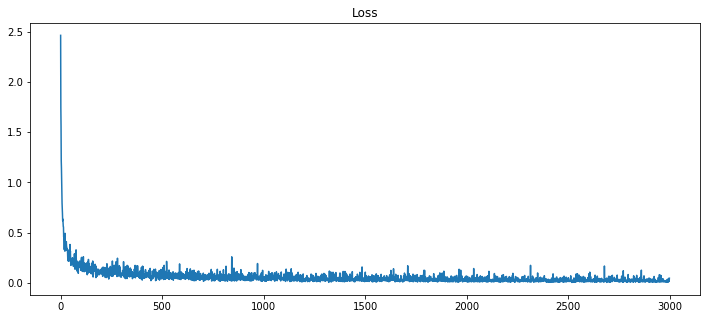

In [29]:
model = CNN_BN(100, 50)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
model_train(model, num_epochs=5)

In [30]:
model_test(model)

Test Accuracy on 10 000 test images: 99.07000000000001 %
Time to test: 0.37 minutes


### Использование RMSprop

In [31]:
# https://github.com/aerinkim/AMS_pytorch/blob/master/AdamFails_1dConvex.ipynb
import math
from torch.optim import Optimizer

class CustomRMSprop(Optimizer):
    
    def __init__(self, params, lr=1e-2, eps=1e-8, alpha=.99):
        
        defaults = dict(lr=lr, eps=eps, alpha=alpha)
        super(CustomRMSprop, self).__init__(params, defaults)
        
    def step(self):
        """ One optimization step. """
        
        loss = None
        for group in self.param_groups:
            for p in group['params']:
                # Weights = p.data
                grad = p.grad.data
                state = self.state[p]
                
                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponentially decaying average of past squared gradients. Denominator.
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    
                exp_avg_sq = state['exp_avg_sq'] # rename 
                state['step'] += 1
                
                exp_avg_sq = torch.mul(exp_avg_sq, group['alpha']) + (1 - group['alpha']) * (grad*grad)#a.mm(a.t())
                denom = exp_avg_sq.sqrt() + group['eps']
                
                p.data -= group['lr'] * grad / denom
                
        return loss

In [32]:
model = CNN(100, 50)
criterion = nn.CrossEntropyLoss()
optimizer = CustomRMSprop(model.parameters(), lr=0.01)

Epoch [1/5], Step [100/600], Loss: 2.3133, Accuracy: 11.00%
Epoch [1/5], Step [200/600], Loss: 2.3162, Accuracy: 10.00%
Epoch [1/5], Step [300/600], Loss: 2.3221, Accuracy: 6.00%
Epoch [1/5], Step [400/600], Loss: 2.2918, Accuracy: 7.00%
Epoch [1/5], Step [500/600], Loss: 2.2915, Accuracy: 14.00%
Epoch [1/5], Step [600/600], Loss: 2.3355, Accuracy: 11.00%
Epoch [2/5], Step [100/600], Loss: 2.3215, Accuracy: 11.00%
Epoch [2/5], Step [200/600], Loss: 2.3245, Accuracy: 6.00%
Epoch [2/5], Step [300/600], Loss: 2.3037, Accuracy: 8.00%
Epoch [2/5], Step [400/600], Loss: 2.3151, Accuracy: 8.00%
Epoch [2/5], Step [500/600], Loss: 2.2937, Accuracy: 15.00%
Epoch [2/5], Step [600/600], Loss: 2.2969, Accuracy: 14.00%
Epoch [3/5], Step [100/600], Loss: 2.2990, Accuracy: 13.00%
Epoch [3/5], Step [200/600], Loss: 2.3488, Accuracy: 9.00%
Epoch [3/5], Step [300/600], Loss: 2.3235, Accuracy: 12.00%
Epoch [3/5], Step [400/600], Loss: 2.3043, Accuracy: 16.00%
Epoch [3/5], Step [500/600], Loss: 2.3169, Acc

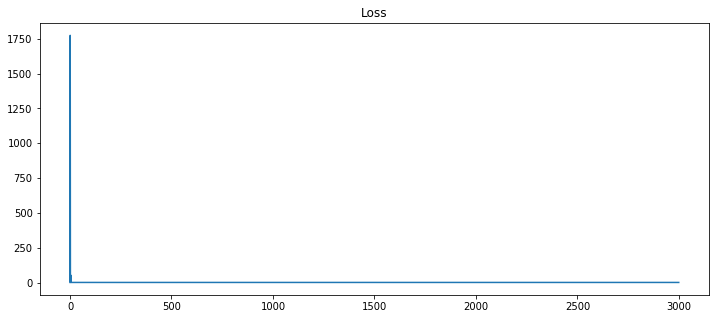

In [33]:
model_train(model, num_epochs=5)

In [34]:
model_test(model)

Test Accuracy on 10 000 test images: 10.100000000000001 %
Time to test: 0.36 minutes


Качество крайне низкое. Попробуем упростить модель, уменьшив число нейронов в слях и скорость обучения

Epoch [1/5], Step [100/600], Loss: 0.2560, Accuracy: 95.00%
Epoch [1/5], Step [200/600], Loss: 0.2917, Accuracy: 93.00%
Epoch [1/5], Step [300/600], Loss: 0.5273, Accuracy: 95.00%
Epoch [1/5], Step [400/600], Loss: 0.4249, Accuracy: 95.00%
Epoch [1/5], Step [500/600], Loss: 0.0451, Accuracy: 99.00%
Epoch [1/5], Step [600/600], Loss: 0.3477, Accuracy: 98.00%
Epoch [2/5], Step [100/600], Loss: 0.1675, Accuracy: 96.00%
Epoch [2/5], Step [200/600], Loss: 0.8165, Accuracy: 92.00%
Epoch [2/5], Step [300/600], Loss: 0.7715, Accuracy: 91.00%
Epoch [2/5], Step [400/600], Loss: 0.2128, Accuracy: 98.00%
Epoch [2/5], Step [500/600], Loss: 0.2112, Accuracy: 97.00%
Epoch [2/5], Step [600/600], Loss: 0.1955, Accuracy: 98.00%
Epoch [3/5], Step [100/600], Loss: 0.4871, Accuracy: 96.00%
Epoch [3/5], Step [200/600], Loss: 0.3480, Accuracy: 92.00%
Epoch [3/5], Step [300/600], Loss: 0.1244, Accuracy: 95.00%
Epoch [3/5], Step [400/600], Loss: 0.4220, Accuracy: 94.00%
Epoch [3/5], Step [500/600], Loss: 0.675

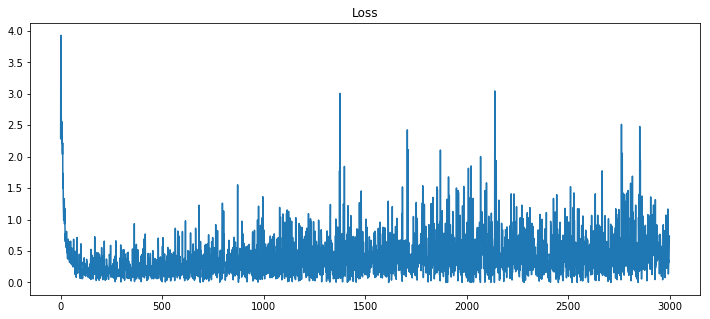

Test Accuracy on 10 000 test images: 92.56 %
Time to test: 0.14 minutes


In [38]:
model = CNN(50, 20)
criterion = nn.CrossEntropyLoss()
optimizer = CustomRMSprop(model.parameters(), lr=0.001)
model_train(model, num_epochs=5)
model_test(model)

Качеству есть куда улучшаться, попробуем в первом слое оставить меньше каналлов, чем во втором

Epoch [1/5], Step [100/600], Loss: 0.1720, Accuracy: 97.00%
Epoch [1/5], Step [200/600], Loss: 0.0944, Accuracy: 97.00%
Epoch [1/5], Step [300/600], Loss: 0.2348, Accuracy: 97.00%
Epoch [1/5], Step [400/600], Loss: 0.2487, Accuracy: 96.00%
Epoch [1/5], Step [500/600], Loss: 0.3725, Accuracy: 96.00%
Epoch [1/5], Step [600/600], Loss: 0.0063, Accuracy: 100.00%
Epoch [2/5], Step [100/600], Loss: 0.4200, Accuracy: 97.00%
Epoch [2/5], Step [200/600], Loss: 0.0802, Accuracy: 99.00%
Epoch [2/5], Step [300/600], Loss: 0.3626, Accuracy: 97.00%
Epoch [2/5], Step [400/600], Loss: 0.3259, Accuracy: 92.00%
Epoch [2/5], Step [500/600], Loss: 0.4064, Accuracy: 98.00%
Epoch [2/5], Step [600/600], Loss: 0.3098, Accuracy: 97.00%
Epoch [3/5], Step [100/600], Loss: 0.0627, Accuracy: 99.00%
Epoch [3/5], Step [200/600], Loss: 0.6873, Accuracy: 91.00%
Epoch [3/5], Step [300/600], Loss: 0.1005, Accuracy: 97.00%
Epoch [3/5], Step [400/600], Loss: 0.2584, Accuracy: 95.00%
Epoch [3/5], Step [500/600], Loss: 0.55

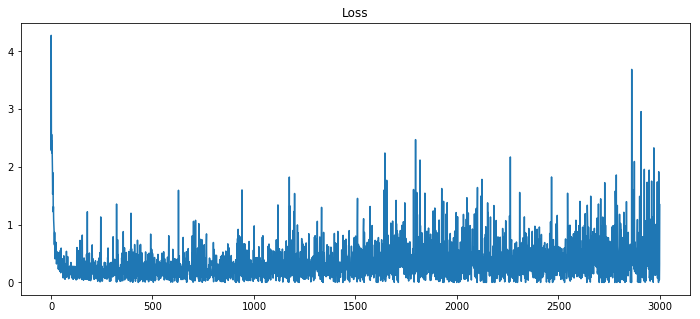

Test Accuracy on 10 000 test images: 97.89 %
Time to test: 0.13 minutes


In [39]:
model = CNN(30, 60)
criterion = nn.CrossEntropyLoss()
optimizer = CustomRMSprop(model.parameters(), lr=0.001)
model_train(model, num_epochs=5)
model_test(model)

Ошибка в последних 2х моделях сходится, но разброс ее значений во время сходимости весьма большой

Построим теперь модель с батч нормом и сравним оптимизаторы: RMSprop и SGD

Epoch [1/5], Step [100/600], Loss: 0.3235, Accuracy: 97.00%
Epoch [1/5], Step [200/600], Loss: 0.2420, Accuracy: 95.00%
Epoch [1/5], Step [300/600], Loss: 0.6970, Accuracy: 96.00%
Epoch [1/5], Step [400/600], Loss: 0.5862, Accuracy: 96.00%
Epoch [1/5], Step [500/600], Loss: 0.5209, Accuracy: 97.00%
Epoch [1/5], Step [600/600], Loss: 0.7016, Accuracy: 97.00%
Epoch [2/5], Step [100/600], Loss: 0.5324, Accuracy: 95.00%
Epoch [2/5], Step [200/600], Loss: 0.2023, Accuracy: 99.00%
Epoch [2/5], Step [300/600], Loss: 0.5436, Accuracy: 97.00%
Epoch [2/5], Step [400/600], Loss: 0.0227, Accuracy: 99.00%
Epoch [2/5], Step [500/600], Loss: 0.0336, Accuracy: 99.00%
Epoch [2/5], Step [600/600], Loss: 0.4232, Accuracy: 99.00%
Epoch [3/5], Step [100/600], Loss: 0.0187, Accuracy: 99.00%
Epoch [3/5], Step [200/600], Loss: 0.4321, Accuracy: 98.00%
Epoch [3/5], Step [300/600], Loss: 0.1566, Accuracy: 99.00%
Epoch [3/5], Step [400/600], Loss: 0.0404, Accuracy: 99.00%
Epoch [3/5], Step [500/600], Loss: 0.106

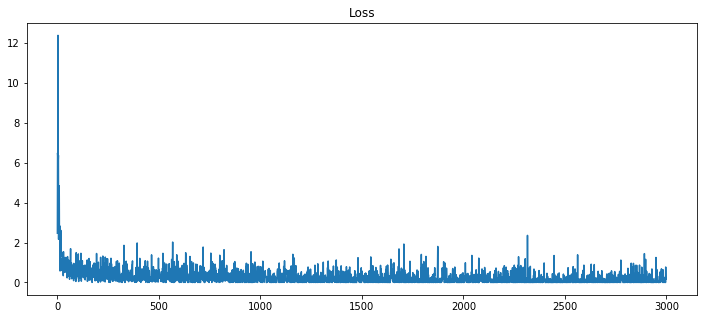

Test Accuracy on 10 000 test images: 98.75 %
Time to test: 0.15 minutes


In [41]:
# RMSprop
model = CNN_BN(30, 60)
criterion = nn.CrossEntropyLoss()
optimizer = CustomRMSprop(model.parameters(), lr=0.001)
model_train(model, num_epochs=5)
model_test(model)

Заметим, что разброс ошибки значительно уменьшился после применения батч норма

Epoch [1/5], Step [100/600], Loss: 0.7262, Accuracy: 83.00%
Epoch [1/5], Step [200/600], Loss: 0.5008, Accuracy: 89.00%
Epoch [1/5], Step [300/600], Loss: 0.4116, Accuracy: 90.00%
Epoch [1/5], Step [400/600], Loss: 0.3720, Accuracy: 91.00%
Epoch [1/5], Step [500/600], Loss: 0.2774, Accuracy: 94.00%
Epoch [1/5], Step [600/600], Loss: 0.2743, Accuracy: 91.00%
Epoch [2/5], Step [100/600], Loss: 0.1359, Accuracy: 98.00%
Epoch [2/5], Step [200/600], Loss: 0.1885, Accuracy: 98.00%
Epoch [2/5], Step [300/600], Loss: 0.2652, Accuracy: 92.00%
Epoch [2/5], Step [400/600], Loss: 0.2460, Accuracy: 93.00%
Epoch [2/5], Step [500/600], Loss: 0.1993, Accuracy: 95.00%
Epoch [2/5], Step [600/600], Loss: 0.1401, Accuracy: 96.00%
Epoch [3/5], Step [100/600], Loss: 0.1543, Accuracy: 95.00%
Epoch [3/5], Step [200/600], Loss: 0.1598, Accuracy: 96.00%
Epoch [3/5], Step [300/600], Loss: 0.1486, Accuracy: 97.00%
Epoch [3/5], Step [400/600], Loss: 0.1049, Accuracy: 97.00%
Epoch [3/5], Step [500/600], Loss: 0.083

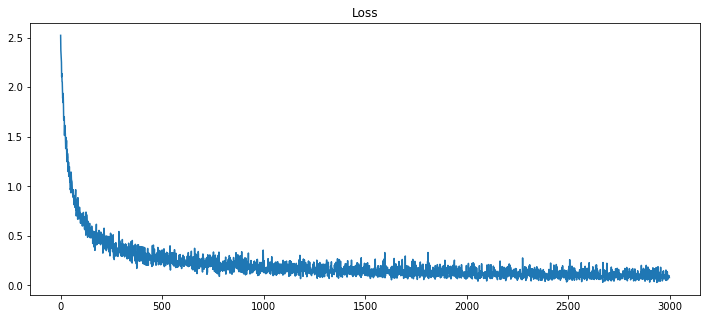

Test Accuracy on 10 000 test images: 97.67 %
Time to test: 0.15 minutes


In [42]:
# SGD
model = CNN_BN(30, 60)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)
model_train(model, num_epochs=5)
model_test(model)

RMSprop показал качество выше, чем SGD на аналогичных гиперпараметрах, accuracy на тесте 98.75%, вместо 97.67% у SGD.